# AFL Fantasy Football Data Analysis
## What is the best fantasy scoring method? Which is the strongest indication that a team will win?
AFL fans often dismiss fantasy scores as irrelevant to the actual match result.

This analysis delves into these results to determine how relevant these fantasy scores are historically, and also pits two of the most popular fantasy score methods (AFL Fantasy and AFL Supercoach) against each other.

A winner will be crowned!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 30)

### Get Footywire Data
This data was scraped using the fitzRoy R Package https://github.com/jimmyday12/fitzRoy.

For this code, refer to fitzroy.R

In [21]:
# Get footywire match data with a row for each player
df_footywire_data = pd.read_csv(r'inputs/footywire_player_matches.csv', index_col=0)
# Drop duplicates
df_footywire_data = df_footywire_data.drop_duplicates()
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5
1,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90416,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0
90417,2019-09-28,2019,Grand Final,MCG,Samuel Reid,GWS,Richmond,Away,9927,5,6,8,66.7,0,0,0,4,0,96,5,7,12,2,0,0,3,0,0,0,1,2,1,0,0,47,55,0.0,1.0,1.0,97.0,2.0,5.0,0.0
90418,2019-09-28,2019,Grand Final,MCG,Adam Kennedy,GWS,Richmond,Away,9927,4,8,9,81.8,0,0,0,1,0,71,5,6,11,4,0,0,4,0,0,2,1,0,0,1,0,56,55,0.0,1.0,1.0,121.0,0.0,5.0,1.0
90419,2019-09-28,2019,Grand Final,MCG,Shane Mumford,GWS,Richmond,Away,9927,8,2,7,70.0,0,0,0,4,0,75,2,8,10,0,0,0,1,15,0,1,2,2,1,1,0,42,62,1.0,1.0,0.0,0.0,1.0,2.0,0.0


### EDA

- Most Supercoach scores are between 0 and 170
- Positively distributed

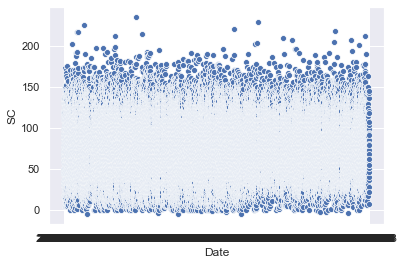

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="Date", y="SC", data=df_footywire_data.loc[: ,['Date', 'SC']])

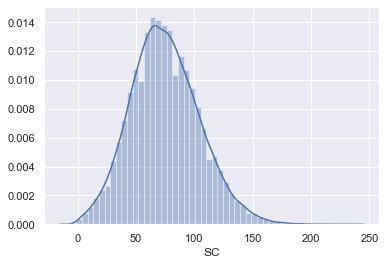

In [23]:
sns.distplot(df_footywire_data['SC'])

### Get the total SuperCoach and AFL Fantasy scores for each team, for every match

In [3]:
# Create a summary to get the total SC and AF points for each match
df_match_summary = pd.pivot_table(df_footywire_data, index=['Match_id'], values=['SC', 'AF'], columns=['Status'], aggfunc=np.sum)
df_match_summary = df_match_summary.reset_index()
df_match_summary.columns = df_match_summary.columns.to_series().str.join('_')
df_match_summary = df_match_summary.rename(columns={'Match_id_': 'Match_id'})
df_match_summary

,Match_id,AF_Away,AF_Home,SC_Away,SC_Home
0,4961,1411,1610,1656,1661
1,4962,1393,1713,1359,1944
2,4963,1452,1900,1332,1973
3,4964,1699,1364,1776,1534
4,4965,1643,1503,1742,1556
...,...,...,...,...,...
2032,9923,1363,1544,1495,1802
2033,9924,1338,1415,1622,1678
2034,9925,1492,1385,1680,1616
2035,9926,1518,1580,1657,1641


### Get actual match information and results
This data was not readily available using the fitzRoy package, to get this data it must be scraped from the footywire site directly.

Refer to scrape_footywire.py for code.

In [4]:
# Get footywire match data with a single row for each match
df_footywire_matches = pd.read_csv(r'Inputs/footywire_team_matches.csv', index_col=0)
df_footywire_matches['away_team'] = df_footywire_matches['away_team'].str.strip()
df_footywire_matches

,year,date,venue,crowd,match_id,home_team,away_team,home_team_score,away_team_score
0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Richmond,Carlton,64,120
1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Geelong,Essendon,125,94
2,2010,Sat 27 Mar 2:10pm,MCG,45615,5091,Melbourne,Hawthorn,61,117
3,2010,Sat 27 Mar 7:10pm,ANZ Stadium,31330,5093,Sydney,St Kilda,88,96
4,2010,Sat 27 Mar 7:30pm,Gabba,29201,5092,Brisbane,West Coast,114,82
...,...,...,...,...,...,...,...,...,...
202,2019,Fri 13 Sep 7:50pm,MCG,51813,9923,Geelong,West Coast,88,68
203,2019,Sat 14 Sep 7:25pm,Gabba,30034,9924,Brisbane,GWS,80,83
204,2019,Fri 20 Sep 7:50pm,MCG,94423,9925,Richmond,Geelong,85,66
205,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,Collingwood,GWS,52,56


### Combine the actual match results with fantasy scoring summaries 

In [5]:
# Merge the fantasy summary and the match scores
df_match_fantasy_summary = pd.merge(df_footywire_matches, df_match_summary,how='left', left_on='match_id', right_on='Match_id')
# Drop bye and cancelled games
df_match_fantasy_summary = df_match_fantasy_summary.drop(df_match_fantasy_summary.loc[df_match_fantasy_summary['venue'] == "BYE"].index)
df_match_fantasy_summary = df_match_fantasy_summary.drop(df_match_fantasy_summary.loc[df_match_fantasy_summary['venue'] == "MATCH CANCELLED"].index)
df_match_fantasy_summary

,year,date,venue,crowd,match_id,home_team,away_team,home_team_score,away_team_score,Match_id,AF_Away,AF_Home,SC_Away,SC_Home
0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Richmond,Carlton,64,120,5089,1938,1250,1986,1321
1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Geelong,Essendon,125,94,5090,1503,1774,1523,1775
2,2010,Sat 27 Mar 2:10pm,MCG,45615,5091,Melbourne,Hawthorn,61,117,5091,1863,1516,1829,1470
3,2010,Sat 27 Mar 7:10pm,ANZ Stadium,31330,5093,Sydney,St Kilda,88,96,5093,1490,1532,1637,1661
4,2010,Sat 27 Mar 7:30pm,Gabba,29201,5092,Brisbane,West Coast,114,82,5092,1543,1607,1609,1691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,2019,Fri 13 Sep 7:50pm,MCG,51813,9923,Geelong,West Coast,88,68,9923,1363,1544,1495,1802
2033,2019,Sat 14 Sep 7:25pm,Gabba,30034,9924,Brisbane,GWS,80,83,9924,1338,1415,1622,1678
2034,2019,Fri 20 Sep 7:50pm,MCG,94423,9925,Richmond,Geelong,85,66,9925,1492,1385,1680,1616
2035,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,Collingwood,GWS,52,56,9926,1518,1580,1657,1641


### Calculate the result for each type of scoring (Actual scoring, AFL Fantasy Scoring, and Supercoach scoring)
For example... the match of Richmond vs Carlton, Round 1 2010

Actual result = Carlton won 120 to 62, therefore this is 'away_win'

AFL Fantasy result = Carlton players scored 1938 points vs Richmond's 1250, therefore this is 'away_win'

SC result = Carlton players scored 1986 points vs Richmond's 1321, therefore this is 'away_win'

In [6]:
# Calculate the match result, the SC result, and the AF result
def get_match_result(home_score, away_score):
    result = ""
    if home_score > away_score:
        result = "home_win"
    elif home_score < away_score:
        result = "away_win"
    elif home_score == away_score:
        result = "tie"
    return result

df_match_fantasy_summary['match_result'] = df_match_fantasy_summary.apply(lambda row: get_match_result(row['home_team_score'], row['away_team_score']), axis=1)
df_match_fantasy_summary['match_result_home_margin'] = df_match_fantasy_summary['home_team_score'] - df_match_fantasy_summary['away_team_score']
df_match_fantasy_summary['match_result_away_margin'] = df_match_fantasy_summary['away_team_score'] - df_match_fantasy_summary['home_team_score']
df_match_fantasy_summary['sc_result'] = df_match_fantasy_summary.apply(lambda row: get_match_result(row['SC_Home'], row['SC_Away']), axis=1)
df_match_fantasy_summary['sc_correct?'] = df_match_fantasy_summary.apply(lambda row: row['sc_result'] == row['match_result'], axis=1)
df_match_fantasy_summary['af_result'] = df_match_fantasy_summary.apply(lambda row: get_match_result(row['AF_Home'], row['AF_Away']), axis=1)
df_match_fantasy_summary['af_correct?'] = df_match_fantasy_summary.apply(lambda row: row['af_result'] == row['match_result'], axis=1)
df_match_fantasy_summary['diff_fantasy_result'] = df_match_fantasy_summary.apply(lambda row: row['sc_result'] != row['af_result'], axis=1)
df_match_fantasy_summary

,year,date,venue,crowd,match_id,home_team,away_team,home_team_score,away_team_score,Match_id,AF_Away,AF_Home,SC_Away,SC_Home,match_result,match_result_home_margin,match_result_away_margin,sc_result,sc_correct?,af_result,af_correct?,diff_fantasy_result
0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Richmond,Carlton,64,120,5089,1938,1250,1986,1321,away_win,-56,56,away_win,True,away_win,True,False
1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Geelong,Essendon,125,94,5090,1503,1774,1523,1775,home_win,31,-31,home_win,True,home_win,True,False
2,2010,Sat 27 Mar 2:10pm,MCG,45615,5091,Melbourne,Hawthorn,61,117,5091,1863,1516,1829,1470,away_win,-56,56,away_win,True,away_win,True,False
3,2010,Sat 27 Mar 7:10pm,ANZ Stadium,31330,5093,Sydney,St Kilda,88,96,5093,1490,1532,1637,1661,away_win,-8,8,home_win,False,home_win,False,False
4,2010,Sat 27 Mar 7:30pm,Gabba,29201,5092,Brisbane,West Coast,114,82,5092,1543,1607,1609,1691,home_win,32,-32,home_win,True,home_win,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,2019,Fri 13 Sep 7:50pm,MCG,51813,9923,Geelong,West Coast,88,68,9923,1363,1544,1495,1802,home_win,20,-20,home_win,True,home_win,True,False
2033,2019,Sat 14 Sep 7:25pm,Gabba,30034,9924,Brisbane,GWS,80,83,9924,1338,1415,1622,1678,away_win,-3,3,home_win,False,home_win,False,False
2034,2019,Fri 20 Sep 7:50pm,MCG,94423,9925,Richmond,Geelong,85,66,9925,1492,1385,1680,1616,home_win,19,-19,away_win,False,away_win,False,False
2035,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,Collingwood,GWS,52,56,9926,1518,1580,1657,1641,away_win,-4,4,away_win,True,home_win,False,True


### View the accuracy of each fantasy scoring method
When a team's players score more supercoach points than the opposition, they win approx 87% of matches.

When a team's players score more AFL Fantasy points than the opposition, they win approx 78% of matches.

In [7]:
sc_series = df_match_fantasy_summary['sc_correct?'].value_counts()
af_series = df_match_fantasy_summary['af_correct?'].value_counts()
data_dict = {
    'sc_correct?': sc_series,
    'af_correct?': af_series
}
df_fantasy_accuracy = pd.DataFrame(data_dict).transpose()
df_fantasy_accuracy['Total'] = df_fantasy_accuracy[True] + df_fantasy_accuracy[False] 
df_fantasy_accuracy['% Correct'] = round((df_fantasy_accuracy[True] / df_fantasy_accuracy['Total']) * 100, 2)
df_fantasy_accuracy

,True,False,Total,% Correct
sc_correct?,1783,254,2037,87.53
af_correct?,1607,430,2037,78.89


### Supercoach is the most accurate measure of indicating wins
Round 1 goes to Supercoach!

### Now to measure how close each fantasy method is at predicting the margin for a match
We can go further with this data, the "best" method should be more closely aligned with the actual margin of a match.

### First... plot the past results (total fantasy score & margin)
There is a clear linear pattern here, teams that score higher are more likely to have a higher winner margin... and vice versa.

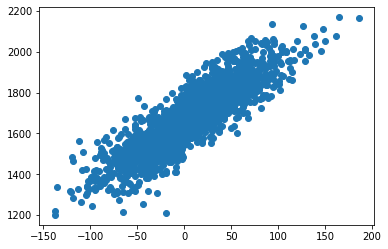

In [8]:
# SC Home team results
plt.scatter(df_match_fantasy_summary['match_result_home_margin'], df_match_fantasy_summary['SC_Home'])
plt.show()

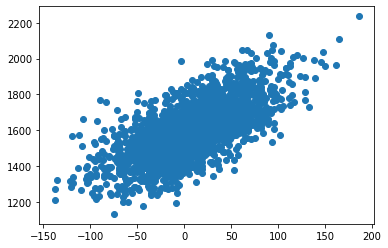

In [9]:
# AF Home team results
plt.scatter(df_match_fantasy_summary['match_result_home_margin'], df_match_fantasy_summary['AF_Home'])
plt.show()

### Build linear regression models for both Fantasy Scoring methods
The method with the least mean squared error rate is the closest at predicting the actual match result.

#### AFL Fantasy

In [10]:
from sklearn import linear_model
from sklearn import model_selection

X = df_match_fantasy_summary['AF_Home']
X = np.array(X).reshape(-1, 1)
y = df_match_fantasy_summary['match_result_home_margin']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.30)

clr = linear_model.LinearRegression()

cv_result = model_selection.cross_val_score(estimator=clr
                                , X=X_train
                                , y=y_train
                                , cv=50
                                , scoring="neg_mean_squared_error"
                                )

cv_result.mean()

-1050.2289401938606

In [11]:
from sklearn import metrics

clr.fit(X_train, y_train)
pred = clr.predict(X_test)
af_mse = metrics.mean_squared_error(pred, y_test)

#### Supercoach

In [12]:
from sklearn import linear_model
from sklearn import model_selection

X = df_match_fantasy_summary['SC_Home']
X = np.array(X).reshape(-1, 1)
y = df_match_fantasy_summary['match_result_home_margin']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.30)

clr = linear_model.LinearRegression()

cv_result = model_selection.cross_val_score(estimator=clr
                                , X=X_train
                                , y=y_train
                                , cv=50
                                , scoring="neg_mean_squared_error"
                                )

cv_result.mean()

-495.37100068619037

In [13]:
from sklearn import metrics

clr.fit(X_train, y_train)
pred = clr.predict(X_test)
sc_mse = metrics.mean_squared_error(pred, y_test)

### Assess the MSE of both Fantasy Methods...
Supercoach score is easily the more reliable indicator of the winning/losing margin

In [14]:
{
    "Supercoach Mean Squared Error": round(sc_mse, 1),
    "AFL Fantasy Mean Squared Error": round(af_mse, 1)
}

{'Supercoach Mean Squared Error': 452.3,
 'AFL Fantasy Mean Squared Error': 1178.9}

### Supercoach Wins! 2-0